# CS 109A/STAT 121A/AC 209A/CSCI E-109A: 
# Final Project - 2017

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine<br/>
**Leading TF**: Albert Wu<br/>
**Project Group #**: 16 (Sports)<br/>
**Project Mmeber: **: Wenxuan (Vince) Wu and Chengye (Ryan) Liu

---

In [274]:
%matplotlib inline
import math
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import IFrame, HTML
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import sys
import json

### Part 1: Data Scraping - Do not rerun at re-start ###

In [ ]:
def process_game_play(url):

    game_pd = pd.read_html(url, header=1)[0]

    # Set proper initial headers
    away_team = game_pd.columns[1]
    home_team = game_pd.columns[5]
    game_pd.columns = ['time', 'away_events','away_pts','score','home_pts','home_events']
    game_pd['away_team'] = away_team
    game_pd['home_team'] = home_team

    # Combine home and away team events
    events = game_pd['home_events']
    events = events.fillna(game_pd['away_events'])
    game_pd['events'] = events
    game_pd['is_home_event'] = 1 - pd.isnull(game_pd['home_events'])

    # Fill invalid scores
    game_pd['score'] = game_pd['score'].replace(to_replace='Score',method='ffill')
    game_pd['score'] = game_pd['score'].fillna(method='backfill')
    game_pd = game_pd.drop(game_pd.index[game_pd['score'].isnull()], axis=0)

    # Process scores
    score_str = game_pd['score'].str.split('-').tolist()
    away_score,home_score = np.transpose(np.array(score_str))
    away_score = away_score.astype(int)
    home_score = home_score.astype(int)
    away_score[:2] = 0
    home_score[:2] = 0
    game_pd['away_score'] = away_score
    game_pd['home_score'] = home_score
    game_pd['score_diff'] = home_score - away_score
    game_pd['home_win'] = (home_score[-1] > away_score[-1]).astype(int)

    # Drop useless columns
    game_pd = game_pd.drop(['away_events', 'away_pts', 'score', 'home_pts', 'home_events'], axis=1)
    
    # Drop the remaining headers rows
    #if any(game_pd['time'].str.contains('Time')):
    ind_header = game_pd.index[game_pd['time'].str.contains('Time')]
    game_pd = game_pd.drop(ind_header, axis=0).reset_index(drop=True)
    #game_pd.reset_index(drop=True)
    
    # Calculate elapsed time
    game_pd['t_elapsed'] = game_pd['time'].str.split(':')
    game_pd = game_pd.drop(game_pd.index[game_pd['time'].str.contains('1st Q')], axis=0).reset_index(drop=True)
    quarter_str = ['2nd Q', '3rd Q', '4th Q', '1st OT', '2nd OT', '3rd OT', '4th OT', '5th OT', '6th OT']
    last_ind = 0
    for i in range(len(quarter_str)):
        if any(game_pd['time'].str.contains(quarter_str[i])):
            ind_list = game_pd.index[game_pd['time'].str.contains(quarter_str[i])]
            ind_Q = ind_list[0]
            game_pd = game_pd.drop(np.arange(ind_Q-1, ind_Q+2, 1).tolist(), axis=0)
            # Special case where multiple 'i-th Q' in the table
            # See https://www.basketball-reference.com/boxscores/pbp/201611110BOS.html
            for j in range(1, len(ind_list)):
                game_pd = game_pd.drop(ind_list[j], axis=0)
                
            game_pd.loc[last_ind:ind_Q, 't_elapsed'] = game_pd.loc[last_ind:ind_Q, 't_elapsed'].apply(
                lambda s: 720*np.min([4, i+1]) + 300*np.max([0, i-3]) - (float(s[0])*60+float(s[1])))
            last_ind = ind_Q
        else:
            last_Q = i
            break
    game_pd.loc[last_ind:, 't_elapsed'] = game_pd.loc[last_ind:, 't_elapsed'].apply(
        lambda s: 720*4 + 300*np.max([0, last_Q-3]) - (float(s[0])*60+float(s[1])))
    game_pd = game_pd.drop(0, axis=0).reset_index(drop=True)

    # Process event information
    event_type = ['makes', 'miss', '2-pt', '3-pt', 'free throw', 'assist', 'Defensive rebound', 
                  'Offensive rebound', 'Turnover', 'foul']
    for e in event_type:
        game_pd[e.replace(' ', '_')] = game_pd['events'].str.contains(e).astype(int)

    game_pd['substitution'] = game_pd['events'].str.contains('enters the game for').astype(int)
    game_pd['timeout'] = game_pd['events'].str.contains('full timeout').astype(int)
    
    # Calculate Shooting percetage
    home_perc = (game_pd['is_home_event']*(game_pd['makes']*(1-game_pd['free_throw']))).cumsum()/(game_pd['is_home_event']*(game_pd['makes']+game_pd['miss']-game_pd['free_throw'])).cumsum()
    home_perc = home_perc.fillna(0)
    away_perc = ((1-game_pd['is_home_event'])*(game_pd['makes']*(1-game_pd['free_throw']))).cumsum()/((1-game_pd['is_home_event'])*(game_pd['makes']+game_pd['miss']-game_pd['free_throw'])).cumsum()
    away_perc = away_perc.fillna(0)

    game_pd['home_perc'] = home_perc
    game_pd['away_perc'] = away_perc
    
    return game_pd


In [ ]:
# Process all games from 2014-2015, 2015-2016, 2016-2017 season

url_base = 'https://www.basketball-reference.com/leagues/NBA_year_games-month.html'

years = ['2015', '2016', '2017']
months = ['october', 'november', 'december', 'january', 'february', 'march', 
         'april', 'may', 'june']

game_urls = []
count = 0
for y in years:
    for m in months:
        url_schedule = url_base.replace('year', y)
        url_schedule = url_schedule.replace('month', m)
        response = requests.get(url_schedule)
        soup = BeautifulSoup(response.text, 'lxml')
        for ref in soup.find_all('a'):
            link = ref.get('href')
            if link.startswith('/boxscores/2'):
                game_urls.append('https://www.basketball-reference.com' + link.replace('boxscores/', 'boxscores/pbp/'))
        count += 1
        sys.stdout.write("\rProgress: %.3f%%" % (100*count/(len(years)*len(months))))
        sys.stdout.flush()

In [ ]:
len(game_urls)

In [ ]:
# Don't rerun this at re-start
# This will take a long time
game_pd_dict = dict()
for ind in range(len(game_urls)):
    game_pd_dict['game_%d' % ind] = process_game_play(game_urls[ind])
    sys.stdout.write("\rProgress: %.3f%%" % (100*(ind+1)/len(game_urls)))
    sys.stdout.flush()

In [ ]:
print(len(game_pd_dict))
game_pd_dict['game_0'].head()

In [ ]:
# Save all the game DataFrames into a xlsx file
writer = pd.ExcelWriter('game_pd_dict.xlsx')
counter = 0
for game in game_pd_dict:
    game_pd_dict[game].to_excel(writer, game)
    counter += 1
    sys.stdout.write("\rProgress: %.3f%%" % (100*count/len(game_pd_dict)))
    sys.stdout.flush()
writer.save()
del game_pd_dict

### Part 2: Load Saved Data - Re-run this at re-start ###

In [3]:
# Read all Processed DataFrame back
game_pd_dict = pd.read_excel('game_pd_dict.xlsx', sheetname=None)

In [4]:
len(game_pd_dict)

3936

#### Plot Wining Percentage Heat Map ####

In [287]:
t_range = np.arange(0, 4081, 1)
l_range = np.arange(-40, 41, 1)

win_count = np.zeros((len(l_range), len(t_range)))
game_count = np.zeros((len(l_range), len(t_range)))

count = 0

for game in game_pd_dict:
    game_pd = game_pd_dict[game]
    t_game = game_pd['t_elapsed'].values
    #l_game = l_range.max() - game_pd['score_diff'].values
    l_game = game_pd['score_diff'].values - l_range.min()
    home_win = game_pd.loc[0, 'home_win']
    
    win_count_temp = np.zeros((len(l_range), len(t_range)))
    game_count_temp = np.zeros((len(l_range), len(t_range)))

    for ind in range(len(game_pd)):
        win_count_temp[np.max([l_game[ind]-2, 0]):np.min([l_game[ind]+2, len(l_range)]), 
                       np.max([t_game[ind]-3, 0]):np.min([t_game[ind]+3, len(t_range)])] = home_win
        game_count_temp[np.max([l_game[ind]-2, 0]):np.min([l_game[ind]+2, len(l_range)]), 
                        np.max([t_game[ind]-3, 0]):np.min([t_game[ind]+3, len(t_range)])] = 1
    
    win_count += win_count_temp
    game_count += game_count_temp
    
    count += 1
    sys.stdout.write("\rProgress: %.3f%%" % (100*count/len(game_pd_dict)))
    sys.stdout.flush()

Progress: 100.000%

In [288]:
game_pd.tail()

,time,away_team,home_team,events,is_home_event,away_score,home_score,score_diff,home_win,t_elapsed,...,assist,Defensive_rebound,Offensive_rebound,Turnover,foul,substitution,timeout,home_perc,away_perc,WP
449,0:42.0,Cleveland,Golden State,S. Curry makes 3-pt shot from 26 ft,1,115,129,14,1,2838,...,0,0,0,0,0,0,0,0.516854,0.523256,0.989529
450,0:37.0,Cleveland,Golden State,L. James makes 2-pt shot from 2 ft,0,117,129,12,1,2843,...,0,0,0,0,0,0,0,0.516854,0.528736,0.986425
451,0:21.0,Cleveland,Golden State,S. Curry misses 3-pt shot from 24 ft,1,117,129,12,1,2859,...,0,0,0,0,0,0,0,0.511111,0.528736,0.973822
452,0:20.0,Cleveland,Golden State,Defensive rebound by T. Thompson,0,117,129,12,1,2860,...,0,1,0,0,0,0,0,0.511111,0.528736,0.972826
453,0:16.0,Cleveland,Golden State,J. Smith makes 3-pt shot from 24 ft (assist by...,0,120,129,9,1,2864,...,1,0,0,0,0,0,0,0.511111,0.534091,0.988971


In [289]:
win_count[0:21, :][win_count[0:21, :] > 0] += 1
win_count[21:61, :][win_count[21:61, :] > 0] += 2
win_count[61:81, :][win_count[61:81, :] > 0] += 3
game_count[game_count > 0] += 4

In [290]:
win_perc = win_count/game_count

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


D:\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


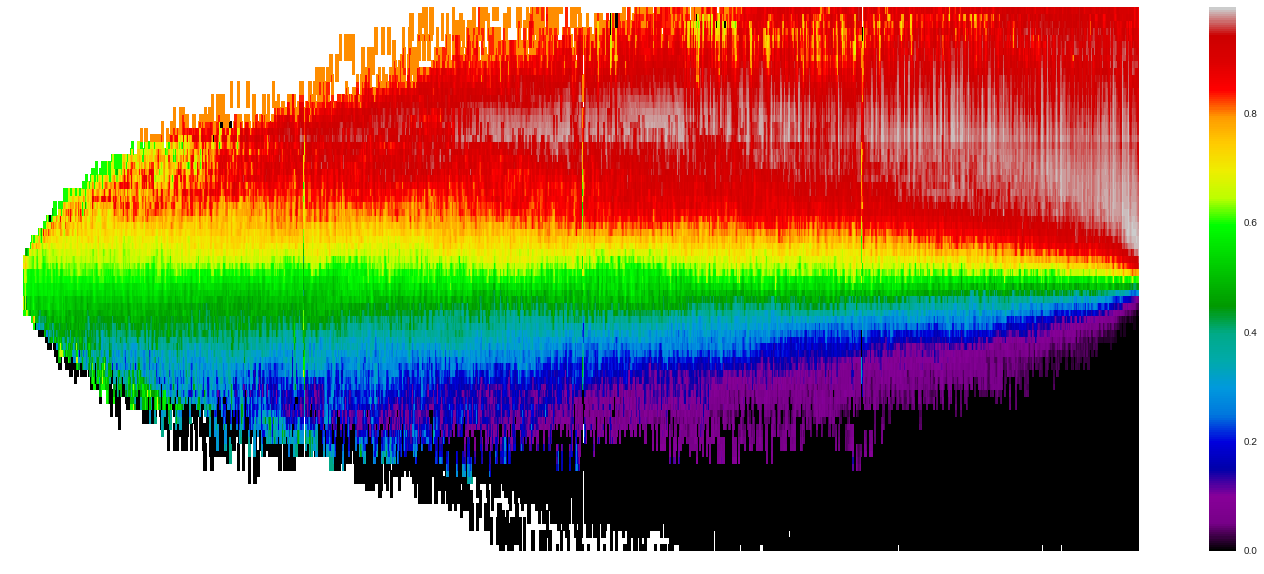

In [291]:
plt.figure(figsize=(25, 10))
plt.axis('off')
sns.heatmap(np.flip(win_perc[:, 0:2881], 0), cmap='spectral')
plt.show()

### Part 3 - Evaluation on WP Changes due to Coach Decisions

#### Step 1: Add WP Column to Game Dataframe

In [292]:
# Add Wining Percentage Column to Dataframe
for game in game_pd_dict:
    game_pd_dict[game]['WP'] = win_perc[(game_pd_dict[game]['score_diff'] - l_range.min()).clip(0, 80), game_pd_dict[game]['t_elapsed']]

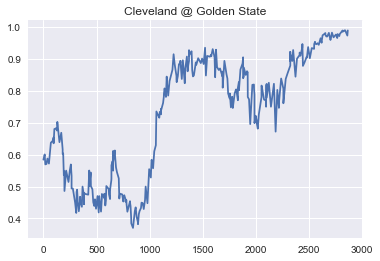

In [293]:
plt.plot(game_pd_dict[game]['t_elapsed'], game_pd_dict[game]['WP'])
plt.title('%s @ %s' % (game_pd_dict[game].loc[0, 'away_team'], game_pd_dict[game].loc[0, 'home_team']))
plt.show()

#### Step 2: Identify Coach Decisions and Calculate Average WP changes

In [294]:
def get_dWP(game_pd, is_home_coach=True):
    # Find row index for coach decision
    if is_home_coach:
        index_init = game_pd.index[((game_pd['substitution']+game_pd['timeout'])*game_pd['is_home_event']) == 1]
    else:
        index_init = game_pd.index[((game_pd['substitution']+game_pd['timeout'])*(1-game_pd['is_home_event'])) == 1]
    index_final = []
    last_t = 0
    for ind in index_init:
        this_t = game_pd_dict[game].loc[ind, 't_elapsed']
        if this_t - last_t > 30: # 30s time frame
            index_final.append(ind)
            last_t = this_t
            
    # Calculate maximum WP changes between two coach decision
    dWP = []
    for j in range(len(index_final)-1):
        if is_home_coach:
            WP_sub = game_pd.loc[index_final[j]:index_final[j+1], 'WP']
        else:
            WP_sub = 1 - game_pd.loc[index_final[j]:index_final[j+1], 'WP']
        dWP_max_ind = (WP_sub - WP_sub[index_final[j]]).abs().argmax()
        dWP.append(WP_sub[dWP_max_ind] - WP_sub[index_final[j]])
    
    return dWP

In [295]:
# Generate the list of WP changed for each coach decisions for all games
dWP_dict = dict()
count = 0
for game in game_pd_dict:
    # Find the WP changes for coach decision
    home_team = game_pd_dict[game].loc[0, 'home_team']
    home_dWP = get_dWP(game_pd_dict[game], is_home_coach=True)
    if home_team in dWP_dict:
        dWP_dict[home_team] += home_dWP
    else:
        dWP_dict[home_team] = home_dWP
    
    away_team = game_pd_dict[game].loc[0, 'away_team']
    away_dWp = get_dWP(game_pd_dict[game], is_home_coach=False)
    if away_team in dWP_dict:
        dWP_dict[away_team] += away_dWp
    else:
        dWP_dict[away_team] = away_dWp
        
    count += 1
    sys.stdout.write("\rProgress: %.3f%%" % (100*count/len(game_pd_dict)))
    sys.stdout.flush()

Progress: 100.000%

In [296]:
team_names = []
dWP_arrays = []
for team in dWP_dict:
    team_names.append(team)
    dWP_arrays.append(np.array(dWP_dict[team]))

In [297]:
sort_index = sorted(np.arange(len(dWP_arrays)), key=lambda i: dWP_arrays[i].mean())
dWP_arrays = [dWP_arrays[j] for j in sort_index]
team_names = [team_names[j] for j in sort_index]

In [298]:
dWP_mean = np.array([m.mean() for m in dWP_arrays])

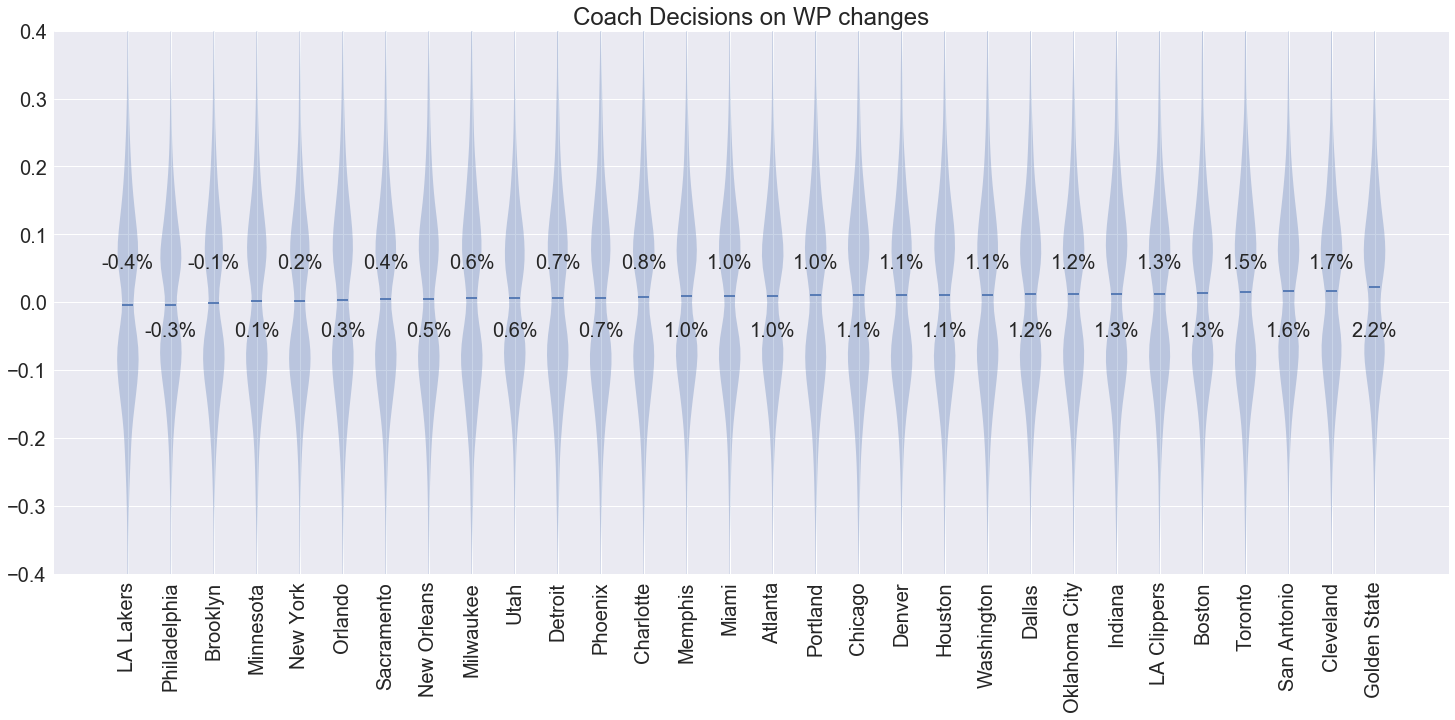

In [299]:
plt.figure(figsize=(25, 10))
plt.violinplot(dWP_arrays, showmeans=True, showextrema=False)
plt.ylim([-0.4, 0.4])
plt.yticks(fontsize=20)
plt.xticks(np.arange(len(team_names))+1, team_names, rotation=90, fontsize=20, horizontalalignment="center")
plt.title('Coach Decisions on WP changes', fontsize=24)
for m, n in zip(dWP_mean, np.arange(len(team_names))):
    plt.annotate('%.1f%%' % (m*100), xy=(n+1, math.pow(-1, n)*0.05), horizontalalignment='center', fontsize=20)
plt.show()

#### Step 3: Conclusion ####

Coach of the Golden State Warriors (Steve Kerr), San Antonio Spurs (Gregg Popovich), Cleveland Cavaliers (Tyrnon Lue, or maybe Lebron?), Toronro Raptors (Dwane Casey) and Boston Celtics (Brad Stevens) have the most positive impact on game wining percentage.

### Part 4: Improved WP Model ###